# Project members

**Sali Raffaele**:
- raffaele.sali@studio.unibo.it
- 000

**Zanotti Niccolò**:
- niccolo.zanotti@studio.unibo.it
- 000

**Zocco Ramazzo Marco**:
- marco.zoccoramazzo@studio.unibo.it
- 000


# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [ ]:
#!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 36.00 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision.transforms import v2
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

In [4]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [5]:
train_dataset1 = OxfordPetDataset(split="train")
print(len(train_dataset1))
img, label = train_dataset1[0]
print(img.size, label)

3669
(300, 225) 0


In [6]:
def breed_from_name(name):
    return "_".join(name.split("_")[:-1])

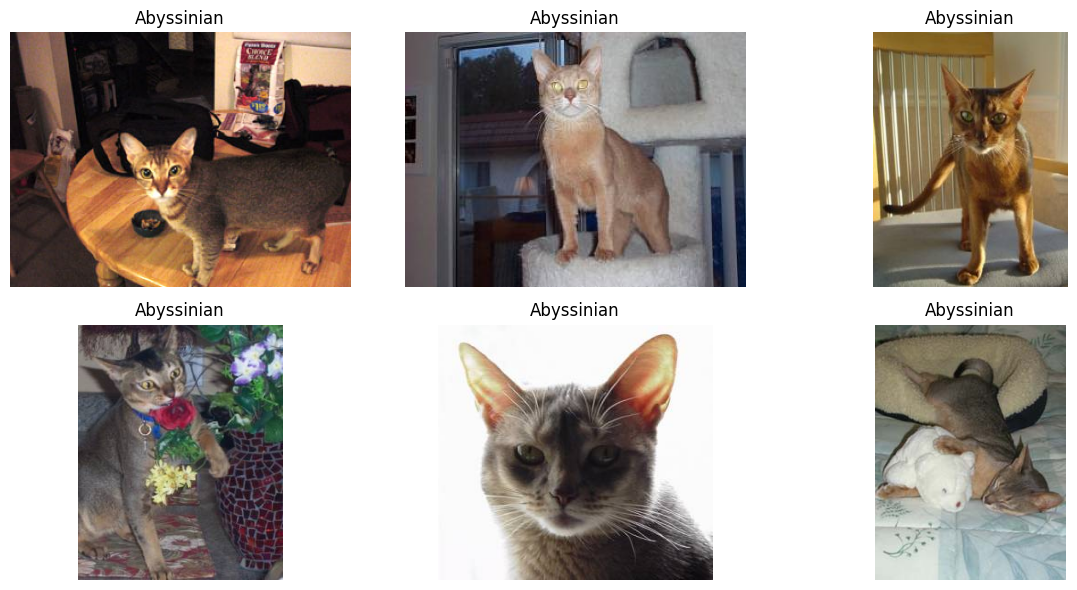

In [7]:
# Images if we don't apply transformations
plt.figure(figsize=(12, 6))
for i in range(6):
    img, _ = train_dataset1[i]
    name = train_dataset1.names[i]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(breed_from_name(name))
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
# Images if we apply transformations
import torchvision.transforms as T

train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = OxfordPetDataset(split="train", transform=train_transform)
test_dataset = OxfordPetDataset(split="test", transform=val_transform)
validation_dataset = OxfordPetDataset(split="val", transform=val_transform)
print("Number of samples - train:", len(train_dataset))
print("Number of classes - train:", train_dataset.get_num_classes())
print("Number of samples - test:", len(test_dataset))
print("Number of classes - test:", test_dataset.get_num_classes())
print("Number of samples - validation:", len(validation_dataset))
print("Number of classes - validation:", validation_dataset.get_num_classes())

Number of samples - train: 3669
Number of classes - train: 37
Number of samples - test: 1846
Number of classes - test: 37
Number of samples - validation: 1834
Number of classes - validation: 37


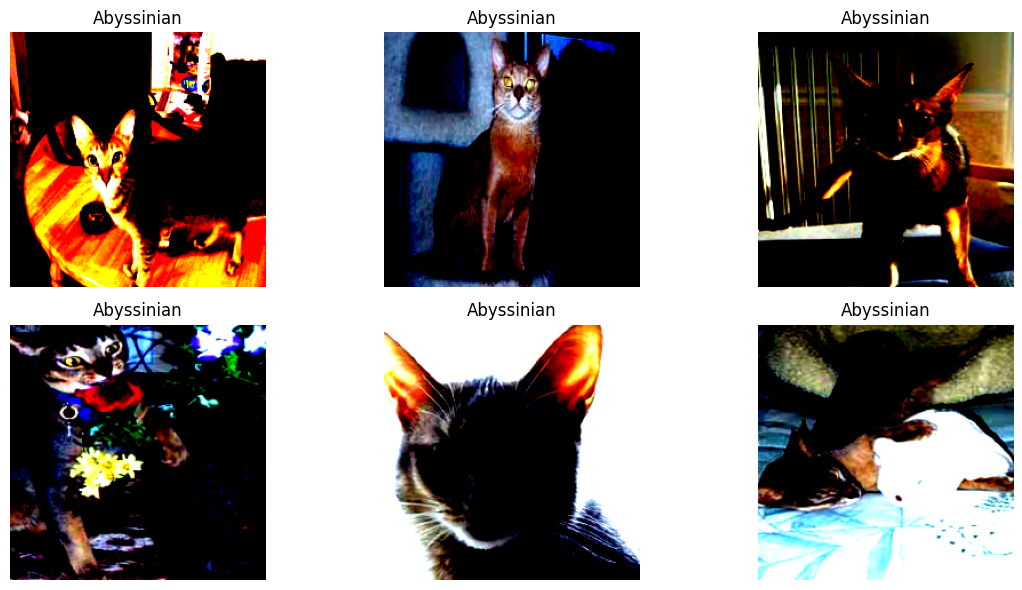

In [9]:
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

def show_samples(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img, _ = dataset[i]
        names = dataset.names[i]
        # label = dataset.labels[i]
        img = img.permute(1, 2, 0)

        plt.subplot(2, n//2, i + 1)
        plt.imshow(img)
        plt.title(f"{breed_from_name(names)}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

In [10]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    validation_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

In [11]:
images, labels = next(iter(train_loader))
print(images.shape)
print(images.min(), images.max())

torch.Size([32, 3, 224, 224])
tensor(-2.1179) tensor(2.6400)


## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

## **NOTE:**
- Several strategies and network architectures were explored, with the main objective of exploiting the components and architectures presented during the course. More advanced networks, such as EfficientNet, were also developed, achieving results very close to those of a simpler ResNet-inspired network. For this reason, the network that better leverages the course topics was ultimately chosen.

## **Common Pipeline**

**Includes:**
- **Accuracy function:** takes into account different output structure when MixUp is employed or not
- **Evaluation function**
- **Residual block class:** defines the structure of the residual blocks, taking into account the presence or not of the Batch Normalization layers
- **Convolutional block class:** defines the structure of the convolutional blocks, which are employed when trying to evidence the impact of Residual blocks
- **Network class:** defines the structure of the CNN, taking into account the use of Stem layers, Batch Normalization layers, Residual layers, Pooling layers and Dropout, to measure the impact of these components
- **TrainConfig class:** defines some core parameters for the training process (like number of epochs, starting learning rate, MixUp parameter, label smoothing factor) and takes into account the use of Label Smoothing, Learning Rate Scheduler and MixUp data augmentation technique
- **build_training_components function:** defines the structure of criterion, optimizer, scheduler and mixup according to boolean and values set in the TrainConfig class
- **Train process function:** defines the pipeline for training the model, minimizing the loss function and updating weights, storing the model with the highest accuracy obtained in validation set

In [11]:
def accuracy(outputs, labels):
    preds = outputs.argmax(dim=1)

    # If labels are one-hot / soft (MixUp case)
    if labels.ndim == 2:
        labels = labels.argmax(dim=1)

    return (preds == labels).sum()

In [12]:
def compute_precision_recall_f1(preds, labels, num_classes):
    eps = 1e-8

    precision_list = []
    recall_list = []
    f1_list = []

    for cls in range(num_classes):
        tp = ((preds == cls) & (labels == cls)).sum().float()
        fp = ((preds == cls) & (labels != cls)).sum().float()
        fn = ((preds != cls) & (labels == cls)).sum().float()

        precision = tp / (tp + fp + eps)
        recall = tp / (tp + fn + eps)
        f1 = 2 * precision * recall / (precision + recall + eps)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return (
        torch.mean(torch.stack(precision_list)).item(),
        torch.mean(torch.stack(recall_list)).item(),
        torch.mean(torch.stack(f1_list)).item(),
    )

In [13]:
def evaluate(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)

            # Handle one-hot / soft labels
            if labels.ndim == 2:
                labels_hard = labels.argmax(dim=1)
            else:
                labels_hard = labels

            total_loss += loss.item() * labels.size(0)
            total_correct += accuracy(outputs, labels)
            total_samples += labels.size(0)

            all_preds.append(preds)
            all_labels.append(labels_hard)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct.float() / total_samples

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    precision, recall, f1 = compute_precision_recall_f1(
        all_preds,
        all_labels,
        num_classes=outputs.size(1)
    )

    return avg_loss, avg_acc.item(), precision, recall, f1

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_batchnorm=True):
        super().__init__()

        norm = nn.BatchNorm2d if use_batchnorm else nn.Identity

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = norm(out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = norm(out_channels)

        # Skip connection adjustment if shape changes
        self.skip = None
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                norm(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.skip is not None:
            identity = self.skip(identity)

        out += identity
        return self.relu(out)

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_batchnorm=True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity(),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.block(x)

In [16]:
class Net(nn.Module):
    def __init__(
        self,
        n_classes,
        use_stem=True,
        use_residuals=True,
        use_batchnorm=True,
        use_pooling=True,
        use_dropout=True
        ):
        super().__init__()

        self.use_residuals = use_residuals

        # Stem layers
        if use_stem:
          self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
          )
        else:
          # Minimal stem: only channel lifting, no downsampling or pooling
          self.stem = nn.Sequential(
              nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
              nn.BatchNorm2d(64) if use_batchnorm else nn.Identity(),
              nn.ReLU()
          )

        # Residual blocks
        self.stage1 = self._make_stage(64, 64, num_blocks=2, stride=1, use_batchnorm=use_batchnorm)
        self.stage2 = self._make_stage(64, 128, num_blocks=2, stride=2, use_batchnorm=use_batchnorm)
        self.stage3 = self._make_stage(128, 256, num_blocks=2, stride=2, use_batchnorm=use_batchnorm)
        self.stage4 = self._make_stage(256, 512, num_blocks=2, stride=2, use_batchnorm=use_batchnorm)

        # Classifier and Pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) if use_pooling else None
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2) if use_dropout else nn.Identity(),
            nn.Linear(256, n_classes)
        )

    def _make_stage(self, in_channels, out_channels, num_blocks, stride, use_batchnorm):
        if not self.use_residuals:
            # Plain conv blocks instead of residual blocks
            layers = [ConvBlock(in_channels, out_channels, stride, use_batchnorm)]
            for _ in range(1, num_blocks):
                layers.append(ConvBlock(out_channels, out_channels, 1, use_batchnorm))
            return nn.Sequential(*layers)
        else:
          layers = [ResidualBlock(in_channels, out_channels, stride, use_batchnorm)]
          for _ in range(1, num_blocks):
              layers.append(ResidualBlock(out_channels, out_channels, use_batchnorm=use_batchnorm))
          return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        if self.pool is not None:
          x = self.pool(x)
        else:
          x = x.mean(dim=(2, 3), keepdim=True)

        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [17]:
from dataclasses import dataclass

@dataclass
class TrainConfig:
    num_epochs: int = 100
    lr: float = 1e-3
    weight_decay: float = 1e-2

    use_scheduler: bool = False
    use_label_smoothing: bool = False
    label_smoothing: float = 0.1

    use_mixup: bool = False
    mixup_alpha: float = 0.2

    save_path : str = None

In [18]:
class NoMixUp:
  def __call__(self, x, y):
    return x, y

In [19]:
def build_training_components(model, train_loader, train_dataset, config: TrainConfig):
  criterion = nn.CrossEntropyLoss(
        label_smoothing=config.label_smoothing
        if config.use_label_smoothing
        else 0.0
    )

  optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )

  scheduler = None
  if config.use_scheduler:
      scheduler = torch.optim.lr_scheduler.OneCycleLR(
          optimizer,
          max_lr=config.lr,
          epochs=config.num_epochs,
          steps_per_epoch=len(train_loader),
          pct_start=0.1,
          anneal_strategy="cos",
      )

  if config.use_mixup:
      mixup = v2.MixUp(
          alpha=config.mixup_alpha,
          num_classes=train_dataset.get_num_classes(),
      )
  else:
      mixup = NoMixUp()

  return criterion, optimizer, scheduler, mixup


In [20]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler=None,
    mixup=None,
    grad_clip=1.0,
    save_path=None,
):
  best_val_acc = 0.0
  history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1": [],
    "lr": [],
  }

  for epoch in range(num_epochs):
      model.train()

      total_loss = 0.0
      total_correct = 0
      total_samples = 0

      for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)

          # Apply MixUp augmentation
          images, labels = mixup(images, labels)

          optimizer.zero_grad()

          outputs = model(images)
          loss = criterion(outputs, labels)

          loss.backward()

          # Gradient clipping to prevent exploding gradients
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

          optimizer.step()
          if scheduler is not None:
            scheduler.step()  # OneCycleLR steps per batch

          total_loss += loss.item() * images.size(0)

          total_correct += accuracy(outputs, labels)
          total_samples += images.size(0)

      train_loss = total_loss / total_samples
      train_acc = total_correct.float() / total_samples

      val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(model, val_loader, criterion, device)

      # Track metrics
      history["train_loss"].append(train_loss)
      history["val_loss"].append(val_loss)
      history["train_acc"].append(train_acc.item())
      history["val_acc"].append(val_acc)
      history["val_precision"].append(val_precision)
      history["val_recall"].append(val_recall)
      history["val_f1"].append(val_f1)
      history["lr"].append(optimizer.param_groups[0]['lr'])

      if save_path is not None and val_acc > best_val_acc:
          best_val_acc = val_acc
          torch.save(model.state_dict(), save_path)

      print(
          f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.2e}"
      )

  print(f"\nBest Validation Accuracy: {best_val_acc:.3f}")
  return best_val_acc, history

In [21]:
def plot_accuracy(history):
    plt.figure()
    plt.plot(history["train_acc"])
    plt.plot(history["val_acc"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend(["Train", "Validation"])
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure()
    plt.plot(history["train_loss"])
    plt.plot(history["val_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend(["Train", "Validation"])
    plt.grid(True)
    plt.show()

def plot_learning_rate(history):
    plt.figure()
    plt.plot(history["lr"])
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid(True)
    plt.show()

## **Model variant: Full model (baseline)**

**Architecture**
- Convolutional neural network implementing architectures and strategies faced during the course.
- A convolutional stem composed of a 7×7 convolution (stride 2), followed by Batch Normalization, ReLU activation, and max pooling.
- Four sequential stages operating at increasing feature dimensions (64 → 128 → 256 → 512).
- Each stage consists of two residual blocks with identity skip connections.
- When spatial resolution or channel dimensions change, skip connections are adapted using a 1×1 convolution followed by Batch Normalization.
- Global feature aggregation is performed using adaptive average pooling.
- The classifier head consists of two fully connected layers with ReLU activation and dropout.

**Normalization and regularization**
- Batch Normalization is applied after every convolution, including within residual branches and skip connections.
- Dropout is applied in the classifier to reduce overfitting.

**Training setup**
- Optimized using AdamW with weight decay.
- Learning rate scheduling is enabled via OneCycleLR with cosine annealing.
- Cross-entropy loss with label smoothing is used.
- MixUp data augmentation is applied during training.
- Gradient norm clipping is used to improve training stability.

**Purpose**
- This configuration serves as the baseline model against which all ablation studies are compared.


**NOTE:** All ablation variants modify a single component at a time while keeping the remaining architecture and training configuration identical to the baseline model.


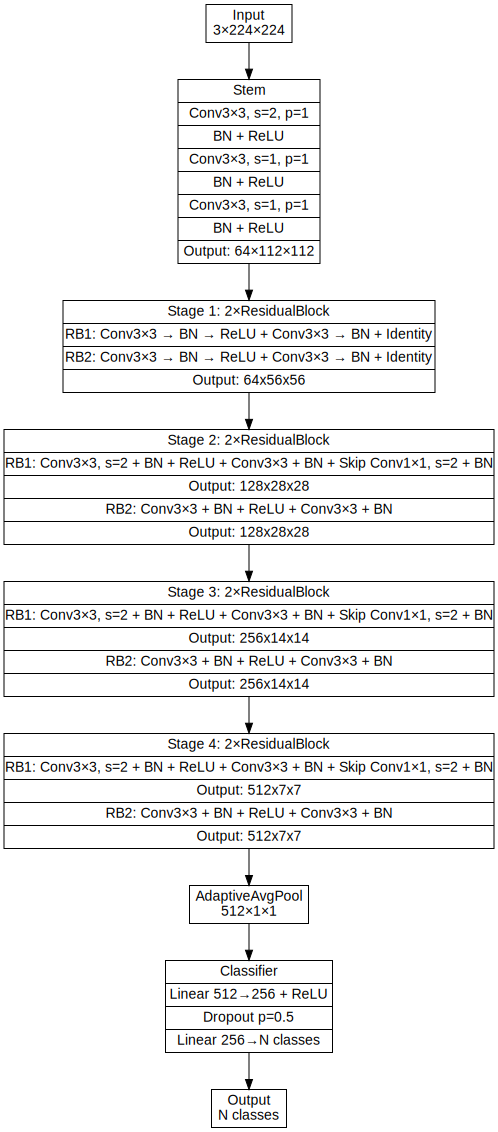

In [1]:
from graphviz import Source

dot_code = r"""
digraph ImprovedNet {
    rankdir=TB;
    fontname="Helvetica";
    node [shape=record, fontname="Helvetica"];

    Input [
        label="Input\n3×224×224"
    ];

    Stem [
        label="{Stem|
        Conv3×3, s=2, p=1|
        BN + ReLU|
        Conv3×3, s=1, p=1|
        BN + ReLU|
        Conv3×3, s=1, p=1|
        BN + ReLU|
        Output: 64×112×112}"
    ];

    Stage1 [
        label="{Stage 1:
        2×ResidualBlock|
        RB1:
        Conv3×3 → BN → ReLU +
        Conv3×3 → BN
        + Identity|
        RB2:
        Conv3×3 → BN → ReLU +
        Conv3×3 → BN
        + Identity|
        Output: 64x56x56}"
    ];

    Stage2 [
        label="{Stage 2:
        2×ResidualBlock|
        RB1:
        Conv3×3, s=2 + BN + ReLU +
        Conv3×3 + BN
        + Skip Conv1×1, s=2 + BN|
        Output: 128x28x28|
        RB2:
        Conv3×3 + BN + ReLU +
        Conv3×3 + BN|
        Output: 128x28x28}"
    ];

    Stage3 [
        label="{Stage 3:
        2×ResidualBlock|
        RB1:
        Conv3×3, s=2 + BN + ReLU +
        Conv3×3 + BN
        + Skip Conv1×1, s=2 + BN|
        Output: 256x14x14|
        RB2:
        Conv3×3 + BN + ReLU +
        Conv3×3 + BN|
        Output: 256x14x14}"
    ];

    Stage4 [
        label="{Stage 4:
        2×ResidualBlock|
        RB1:
        Conv3×3, s=2 + BN + ReLU +
        Conv3×3 + BN
        + Skip Conv1×1, s=2 + BN|
        Output: 512x7x7|
        RB2:
        Conv3×3 + BN + ReLU +
        Conv3×3 + BN|
        Output: 512x7x7}"
    ];

    Pool [
        label="AdaptiveAvgPool\n512×1×1"
    ];

    FC [
        label="{Classifier|
        Linear 512→256 + ReLU|
        Dropout p=0.2|
        Linear 256→N classes}"
    ];

    Output [
        label="Output\nN classes"
    ];

    Input -> Stem -> Stage1 -> Stage2 -> Stage3 -> Stage4 -> Pool -> FC -> Output;
}
"""

Source(dot_code)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Model_1 = Net(n_classes=train_dataset.get_num_classes()).to(device)

# Count parameters
total_params = sum(p.numel() for p in Model_1.parameters())
trainable_params = sum(p.numel() for p in Model_1.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,317,349
Trainable parameters: 11,317,349


In [24]:
config = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=True,
    save_path="best_full_net.pth",
)

criterion, optimizer, scheduler, mixup = build_training_components(
    model = Model_1,
    train_loader=train_loader,
    train_dataset=train_dataset,
    config=config,
)

best_acc, history = train_model(
    model=Model_1,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    mixup=mixup,
    device=device,
    num_epochs=config.num_epochs,
    save_path=config.save_path,
)

Epoch [1/100] | Train Loss: 3.029, Train Acc: 0.207 | Val Loss: 2.923, Val Acc: 0.223 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 2.970, Train Acc: 0.231 | Val Loss: 2.890, Val Acc: 0.211 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 2.941, Train Acc: 0.232 | Val Loss: 2.888, Val Acc: 0.220 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 2.950, Train Acc: 0.237 | Val Loss: 2.920, Val Acc: 0.221 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 3.001, Train Acc: 0.244 | Val Loss: 2.947, Val Acc: 0.209 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 2.937, Train Acc: 0.241 | Val Loss: 3.379, Val Acc: 0.149 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 2.997, Train Acc: 0.238 | Val Loss: 3.136, Val Acc: 0.165 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 2.959, Train Acc: 0.250 | Val Loss: 3.009, Val Acc: 0.198 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 2.957, Train Acc: 0.248 | Val Loss: 3.221, Val Acc: 0.167 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 2.951, Train Acc: 0.262 | Val Loss: 2.899, Val Acc: 0.233 | LR

In [25]:
best_model1 = Model_1

best_model1.load_state_dict(
    torch.load(config.save_path, map_location=device)
)

best_model1.to(device)

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(best_model1, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Test Loss: 1.583
Test Accuracy: 0.695


In [ ]:
results = []

results.append({
    "Model": "Baseline",
    "Test Loss": test_loss,
    "Test Accuracy": test_acc,
    "Test Precision": test_prec,
    "Test Recall": test_recall,
    "Test F1": test_f1
})

In [ ]:
all_histories = {}

all_histories["Baseline"] = history

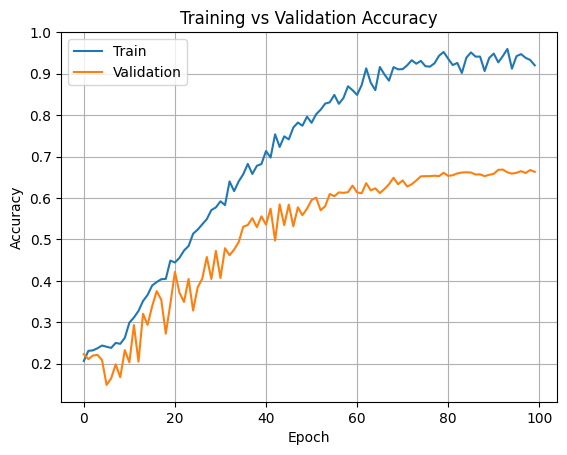

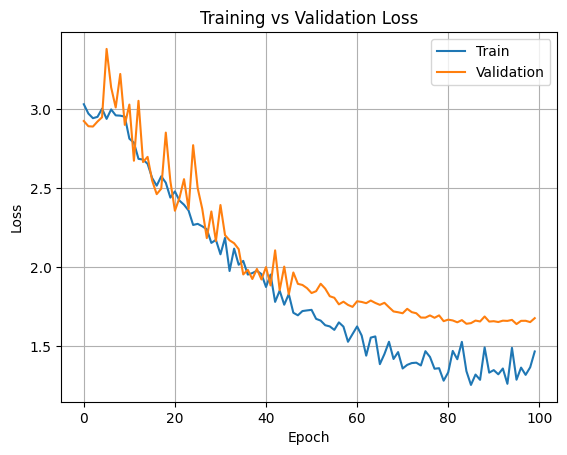

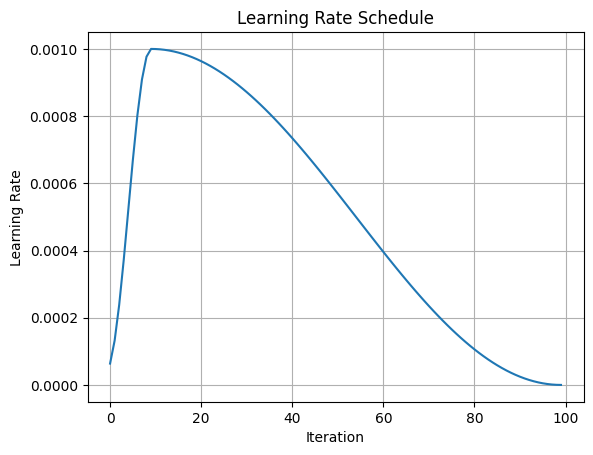

In [26]:
plot_accuracy(history)
plot_loss(history)
plot_learning_rate(history)

## **Model variant: No Batch Normalization**

**Change**
- Removed all Batch Normalization layers from the network, including those in residual skip connections.

**Purpose**
- To assess the contribution of Batch Normalization to training stability and final performance.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Model_2 = Net(n_classes=train_dataset.get_num_classes(), use_batchnorm=False).to(device)

# Count parameters
total_params = sum(p.numel() for p in Model_2.parameters())
trainable_params = sum(p.numel() for p in Model_2.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,307,749
Trainable parameters: 11,307,749


In [ ]:
config2 = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=True,
    save_path="best_noBN_net.pth",
)

criterion2, optimizer2, scheduler2, mixup2 = build_training_components(
    model = Model_2,
    train_loader=train_loader,
    train_dataset=train_dataset,
    config=config2,
)

best_acc2, history2 = train_model(
    model=Model_2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion2,
    optimizer=optimizer2,
    scheduler=scheduler2,
    mixup=mixup2,
    device=device,
    num_epochs=config2.num_epochs,
    save_path=config2.save_path,
)

Epoch [1/100] | Train Loss: 3.612, Train Acc: 0.028 | Val Loss: 3.611, Val Acc: 0.032 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 3.601, Train Acc: 0.037 | Val Loss: 3.602, Val Acc: 0.031 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 3.573, Train Acc: 0.043 | Val Loss: 3.570, Val Acc: 0.032 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 3.561, Train Acc: 0.045 | Val Loss: 3.569, Val Acc: 0.038 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 3.527, Train Acc: 0.053 | Val Loss: 3.524, Val Acc: 0.047 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 3.504, Train Acc: 0.058 | Val Loss: 3.514, Val Acc: 0.060 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 3.511, Train Acc: 0.063 | Val Loss: 3.494, Val Acc: 0.051 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 3.488, Train Acc: 0.072 | Val Loss: 3.470, Val Acc: 0.053 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 3.466, Train Acc: 0.074 | Val Loss: 3.486, Val Acc: 0.054 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 3.451, Train Acc: 0.068 | Val Loss: 3.427, Val Acc: 0.075 | LR

In [ ]:
best_model2 = Model_2

best_model2.load_state_dict(
    torch.load(config2.save_path, map_location=device)
)

best_model2.to(device)

test_loss2, test_acc2, test_prec2, test_recall2, test_f12 = evaluate(best_model2, test_loader, criterion2, device)

print(f"Test Loss: {test_loss2:.3f}")
print(f"Test Accuracy: {test_acc2:.3f}")

Test Loss: 2.447
Test Accuracy: 0.428


In [ ]:
results.append({
    "Model": "No BatchNorm",
    "Test Loss": test_loss2,
    "Test Accuracy": test_acc2,
    "Test Precision": test_prec2,
    "Test Recall": test_recall2,
    "Test F1": test_f12
})

In [ ]:
all_histories["No BatchNorm"] = history2

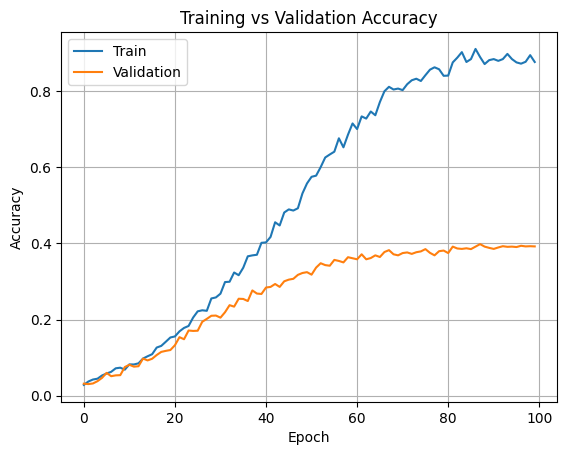

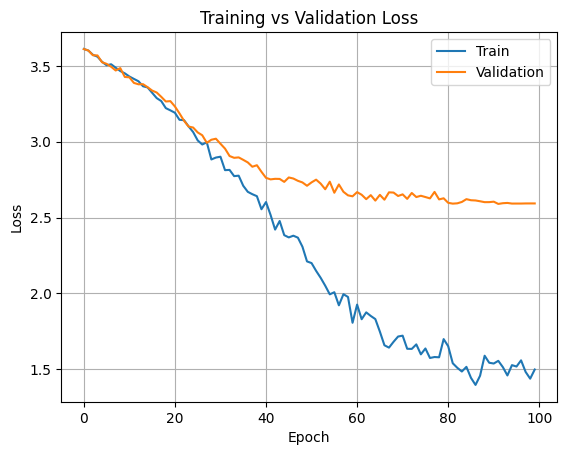

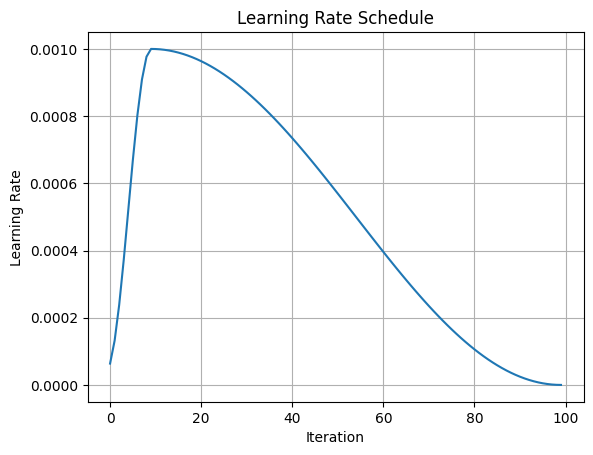

In [ ]:
plot_accuracy(history2)
plot_loss(history2)
plot_learning_rate(history2)

## **Model variant: No Pooling**

**Change**
- Removed all pooling operations from the network, including max pooling in the stem and global average pooling before the classifier.

**Purpose**
- To evaluate the role of spatial downsampling and global feature aggregation in representation learning and classification performance.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Model_3 = Net(n_classes=train_dataset.get_num_classes(), use_pooling=False).to(device)

# Count parameters
total_params = sum(p.numel() for p in Model_3.parameters())
trainable_params = sum(p.numel() for p in Model_3.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,317,349
Trainable parameters: 11,317,349


In [ ]:
config3 = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=True,
    save_path="best_noPOOL_net.pth",
)

criterion3, optimizer3, scheduler3, mixup3 = build_training_components(
    model = Model_3,
    train_loader=train_loader,
    train_dataset=train_dataset,
    config=config3,
)

best_acc3, history3 = train_model(
    model=Model_3,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion3,
    optimizer=optimizer3,
    scheduler=scheduler3,
    mixup=mixup3,
    device=device,
    num_epochs=config3.num_epochs,
    save_path=config3.save_path,
)

Epoch [1/100] | Train Loss: 3.592, Train Acc: 0.045 | Val Loss: 3.555, Val Acc: 0.053 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 3.521, Train Acc: 0.074 | Val Loss: 3.525, Val Acc: 0.057 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 3.497, Train Acc: 0.076 | Val Loss: 3.556, Val Acc: 0.068 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 3.469, Train Acc: 0.077 | Val Loss: 4.540, Val Acc: 0.052 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 3.432, Train Acc: 0.097 | Val Loss: 3.984, Val Acc: 0.058 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 3.416, Train Acc: 0.092 | Val Loss: 3.646, Val Acc: 0.086 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 3.375, Train Acc: 0.106 | Val Loss: 3.830, Val Acc: 0.062 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 3.363, Train Acc: 0.108 | Val Loss: 3.357, Val Acc: 0.099 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 3.314, Train Acc: 0.131 | Val Loss: 3.587, Val Acc: 0.085 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 3.292, Train Acc: 0.129 | Val Loss: 3.512, Val Acc: 0.104 | LR

In [ ]:
best_model3 = Model_3

best_model3.load_state_dict(
    torch.load(config3.save_path, map_location=device)
)

best_model3.to(device)

test_loss3, test_acc3, test_prec3, test_recall3, test_f13 = evaluate(best_model3, test_loader, criterion3, device)

print(f"Test Loss: {test_loss3:.3f}")
print(f"Test Accuracy: {test_acc3:.3f}")

Test Loss: 1.510
Test Accuracy: 0.716


In [ ]:
results.append({
    "Model": "No Pooling",
    "Test Loss": test_loss3,
    "Test Accuracy": test_acc3,
    "Test Precision": test_prec3,
    "Test Recall": test_recall3,
    "Test F1": test_f13
})

In [ ]:
all_histories["No Pooling"] = history3

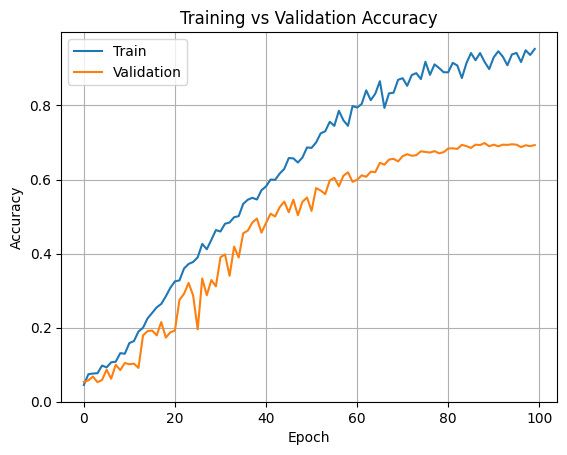

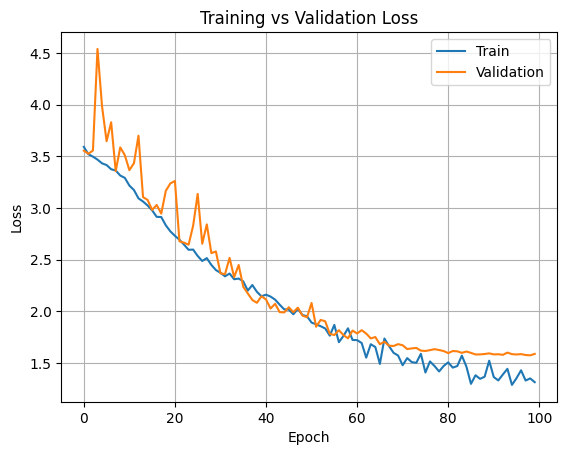

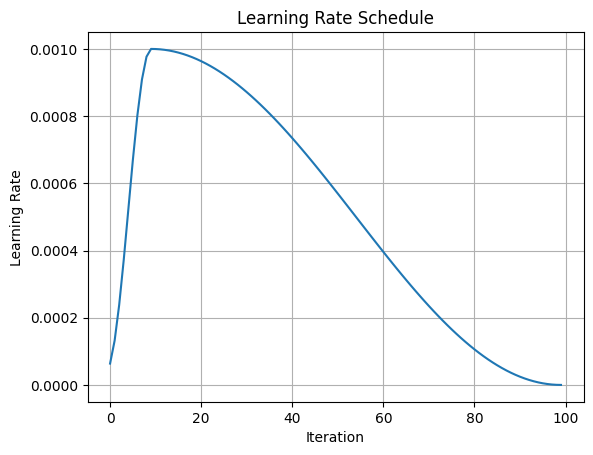

In [ ]:
plot_accuracy(history3)
plot_loss(history3)
plot_learning_rate(history3)

## **Model variant: No Dropout**

**Change**
- Removed dropout from the classifier head while keeping the rest of the architecture unchanged.

**Purpose**
- To assess the impact of dropout-based regularization on overfitting and generalization performance.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Model_4 = Net(n_classes=train_dataset.get_num_classes(), use_dropout=False).to(device)

# Count parameters
total_params = sum(p.numel() for p in Model_4.parameters())
trainable_params = sum(p.numel() for p in Model_4.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,317,349
Trainable parameters: 11,317,349


In [ ]:
config4 = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=True,
    save_path="best_noDOUT_net.pth",
)

criterion4, optimizer4, scheduler4, mixup4 = build_training_components(
    model = Model_4,
    train_loader=train_loader,
    train_dataset=train_dataset,
    config=config4,
)

best_acc4, history4 = train_model(
    model=Model_4,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion4,
    optimizer=optimizer4,
    scheduler=scheduler4,
    mixup=mixup4,
    device=device,
    num_epochs=config4.num_epochs,
    save_path=config4.save_path,
)

Epoch [1/100] | Train Loss: 3.537, Train Acc: 0.064 | Val Loss: 3.483, Val Acc: 0.074 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 3.372, Train Acc: 0.109 | Val Loss: 3.596, Val Acc: 0.076 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 3.286, Train Acc: 0.132 | Val Loss: 3.365, Val Acc: 0.109 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 3.237, Train Acc: 0.144 | Val Loss: 3.349, Val Acc: 0.113 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 3.202, Train Acc: 0.149 | Val Loss: 3.677, Val Acc: 0.076 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 3.162, Train Acc: 0.175 | Val Loss: 3.365, Val Acc: 0.108 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 3.074, Train Acc: 0.195 | Val Loss: 3.468, Val Acc: 0.097 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 3.022, Train Acc: 0.210 | Val Loss: 3.508, Val Acc: 0.130 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 2.973, Train Acc: 0.225 | Val Loss: 3.413, Val Acc: 0.125 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 2.892, Train Acc: 0.247 | Val Loss: 3.225, Val Acc: 0.160 | LR

In [ ]:
best_model4 = Model_4

best_model4.load_state_dict(
    torch.load(config4.save_path, map_location=device)
)

best_model4.to(device)

test_loss4, test_acc4, test_prec4, test_recall4, test_f14 = evaluate(best_model4, test_loader, criterion4, device)

print(f"Test Loss: {test_loss4:.3f}")
print(f"Test Accuracy: {test_acc4:.3f}")

Test Loss: 1.543
Test Accuracy: 0.715


In [ ]:
results.append({
    "Model": "No Dropout",
    "Test Loss": test_loss4,
    "Test Accuracy": test_acc4,
    "Test Precision": test_prec4,
    "Test Recall": test_recall4,
    "Test F1": test_f14
})

In [ ]:
all_histories["No Dropout"] = history4

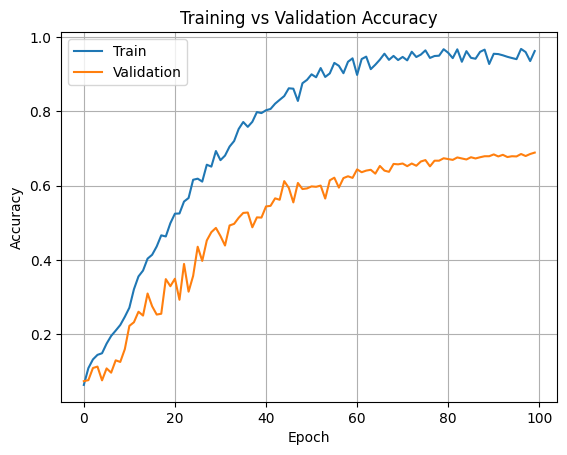

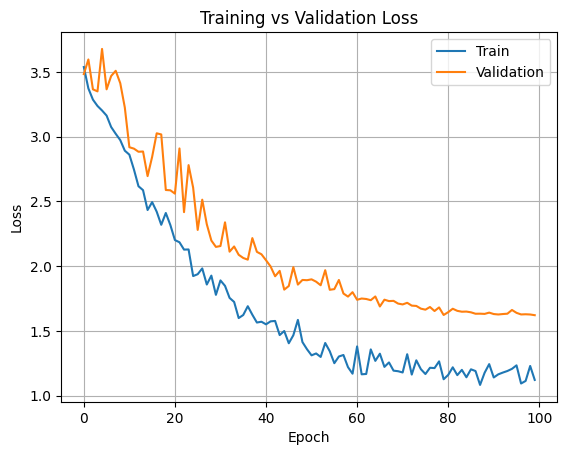

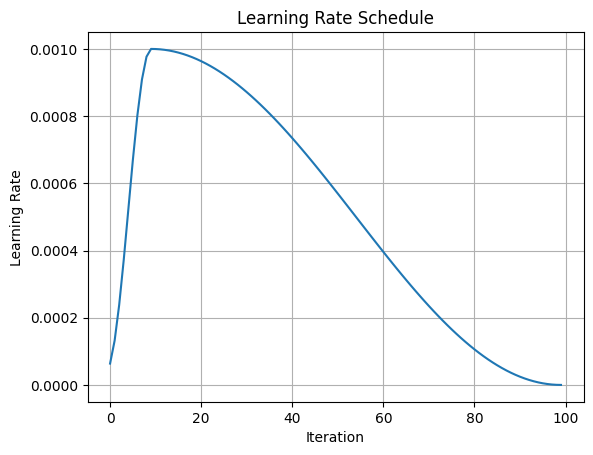

In [ ]:
plot_accuracy(history4)
plot_loss(history4)
plot_learning_rate(history4)

## **Model variant: No MixUp**

**Change**
- Disabled MixUp data augmentation during training, using only standard input–label pairs.

**Purpose**
- To measure the effect of MixUp on model robustness and generalization compared to standard supervised training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Model_5 = Net(n_classes=train_dataset.get_num_classes()).to(device)

# Count parameters
total_params = sum(p.numel() for p in Model_5.parameters())
trainable_params = sum(p.numel() for p in Model_5.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,317,349
Trainable parameters: 11,317,349


In [ ]:
config5 = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=False,
    save_path="best_noMIXUP_net.pth",
)

criterion5, optimizer5, scheduler5, mixup5 = build_training_components(
    model = Model_5,
    train_loader=train_loader,
    train_dataset=train_dataset,
    config=config5,
)

best_acc5, history5 = train_model(
    model=Model_5,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion5,
    optimizer=optimizer5,
    scheduler=scheduler5,
    mixup=mixup5,
    device=device,
    num_epochs=config5.num_epochs,
    save_path=config5.save_path,
)

Epoch [1/100] | Train Loss: 3.565, Train Acc: 0.051 | Val Loss: 3.509, Val Acc: 0.067 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 3.464, Train Acc: 0.080 | Val Loss: 3.514, Val Acc: 0.079 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 3.398, Train Acc: 0.095 | Val Loss: 3.576, Val Acc: 0.075 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 3.324, Train Acc: 0.105 | Val Loss: 4.027, Val Acc: 0.075 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 3.294, Train Acc: 0.114 | Val Loss: 3.681, Val Acc: 0.056 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 3.269, Train Acc: 0.130 | Val Loss: 3.783, Val Acc: 0.081 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 3.220, Train Acc: 0.137 | Val Loss: 3.927, Val Acc: 0.077 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 3.148, Train Acc: 0.155 | Val Loss: 3.718, Val Acc: 0.069 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 3.120, Train Acc: 0.162 | Val Loss: 3.776, Val Acc: 0.094 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 3.044, Train Acc: 0.183 | Val Loss: 3.235, Val Acc: 0.136 | LR

In [ ]:
best_model5 = Model_5

best_model5.load_state_dict(
    torch.load(config5.save_path, map_location=device)
)

best_model5.to(device)

test_loss5, test_acc5, test_prec5, test_recall5, test_f15 = evaluate(best_model5, test_loader, criterion5, device)

print(f"Test Loss: {test_loss5:.3f}")
print(f"Test Accuracy: {test_acc5:.3f}")

Test Loss: 1.591
Test Accuracy: 0.699


In [ ]:
results.append({
    "Model": "No MixUp",
    "Test Loss": test_loss5,
    "Test Accuracy": test_acc5,
    "Test Precision": test_prec5,
    "Test Recall": test_recall5,
    "Test F1": test_f15
})

In [ ]:
all_histories["No MixUp"] = history5

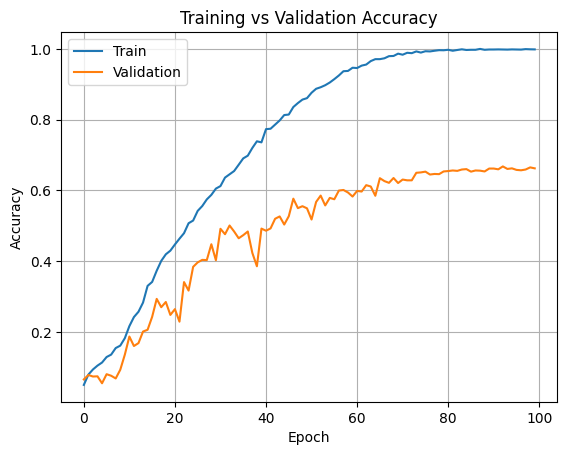

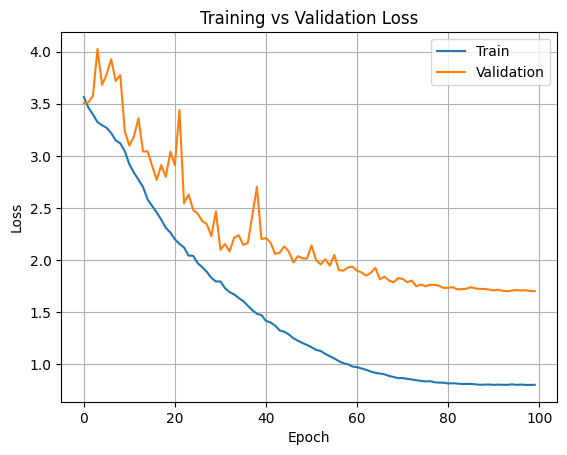

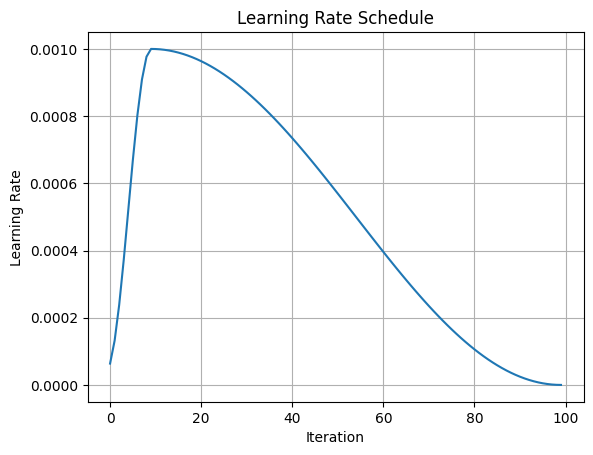

In [ ]:
plot_accuracy(history5)
plot_loss(history5)
plot_learning_rate(history5)

## **Model variant: No Data Augmentation**

**Change**
- Disabled all data augmentation techniques during training, including MixUp and any other stochastic input transformations.

**Purpose**
- To isolate the contribution of data augmentation to model generalization and performance on unseen data.

In [ ]:
train_transform2 = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset2 = OxfordPetDataset(split="train", transform=train_transform2)

train_loader2 = DataLoader(
    train_dataset2,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Model_6 = Net(n_classes=train_dataset.get_num_classes()).to(device)

# Count parameters
total_params = sum(p.numel() for p in Model_6.parameters())
trainable_params = sum(p.numel() for p in Model_6.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,317,349
Trainable parameters: 11,317,349


In [ ]:
config6 = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=False,
    save_path="best_noAUGM_net.pth",
)

criterion6, optimizer6, scheduler6, mixup6 = build_training_components(
    model = Model_6,
    train_loader=train_loader2,
    train_dataset=train_dataset2,
    config=config6,
)

best_acc6, history6 = train_model(
    model=Model_6,
    train_loader=train_loader2,
    val_loader=val_loader,
    criterion=criterion6,
    optimizer=optimizer6,
    scheduler=scheduler6,
    mixup=mixup6,
    device=device,
    num_epochs=config6.num_epochs,
    save_path=config6.save_path,
)

Epoch [1/100] | Train Loss: 3.575, Train Acc: 0.045 | Val Loss: 3.524, Val Acc: 0.063 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 3.420, Train Acc: 0.098 | Val Loss: 3.608, Val Acc: 0.065 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 3.361, Train Acc: 0.114 | Val Loss: 3.540, Val Acc: 0.086 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 3.268, Train Acc: 0.119 | Val Loss: 3.580, Val Acc: 0.088 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 3.174, Train Acc: 0.150 | Val Loss: 3.660, Val Acc: 0.068 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 3.120, Train Acc: 0.164 | Val Loss: 4.362, Val Acc: 0.069 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 2.991, Train Acc: 0.192 | Val Loss: 3.387, Val Acc: 0.120 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 2.903, Train Acc: 0.228 | Val Loss: 3.674, Val Acc: 0.108 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 2.797, Train Acc: 0.244 | Val Loss: 3.882, Val Acc: 0.092 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 2.694, Train Acc: 0.277 | Val Loss: 3.106, Val Acc: 0.213 | LR

In [ ]:
best_model6 = Model_6

best_model6.load_state_dict(
    torch.load(config6.save_path, map_location=device)
)

best_model6.to(device)

test_loss6, test_acc6, test_prec6, test_recall6, test_f16 = evaluate(best_model6, test_loader, criterion6, device)

print(f"Test Loss: {test_loss6:.3f}")
print(f"Test Accuracy: {test_acc6:.3f}")

Test Loss: 2.355
Test Accuracy: 0.459


In [ ]:
results.append({
    "Model": "No Augmentation",
    "Test Loss": test_loss6,
    "Test Accuracy": test_acc6,
    "Test Precision": test_prec6,
    "Test Recall": test_recall6,
    "Test F1": test_f16
})

In [ ]:
all_histories["No Augmentation"] = history6

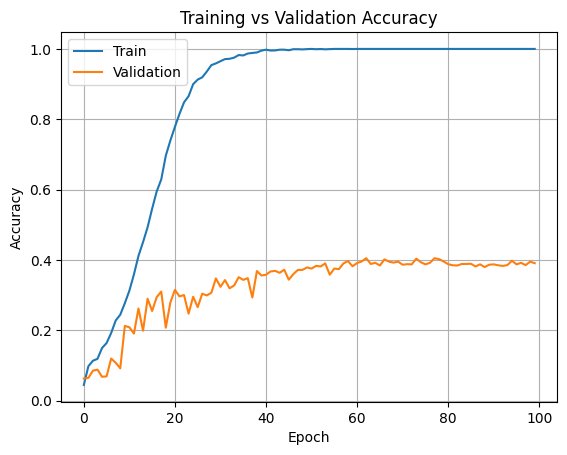

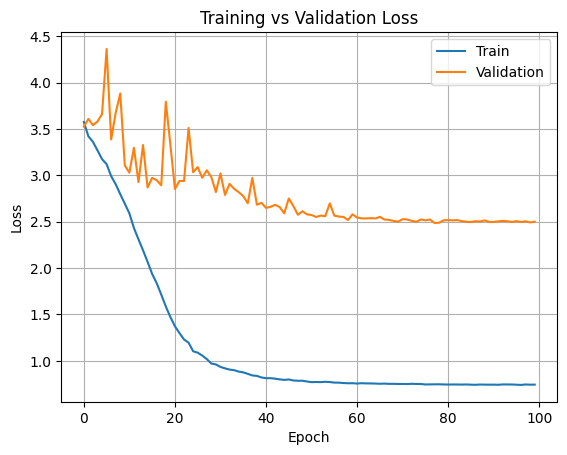

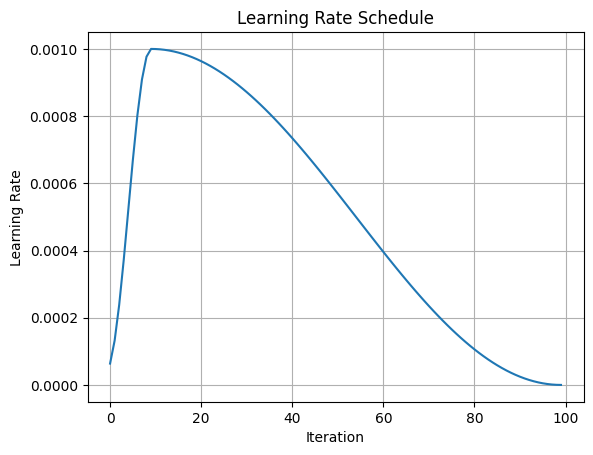

In [ ]:
plot_accuracy(history6)
plot_loss(history6)
plot_learning_rate(history6)

## **Model variant: No Stem Layer**

**Change**
- Removed the convolutional stem (7×7 convolution, Batch Normalization, ReLU, and max pooling), feeding inputs directly into the first stage of the network.

**Purpose**
- To investigate the importance of early-stage feature extraction and aggressive spatial downsampling.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Model_7 = Net(n_classes=train_dataset.get_num_classes(), use_stem=False).to(device)

# Count parameters
total_params = sum(p.numel() for p in Model_7.parameters())
trainable_params = sum(p.numel() for p in Model_7.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,309,669
Trainable parameters: 11,309,669


In [ ]:
config7 = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=True,
    save_path="best_noSTEM_net.pth",
)

criterion7, optimizer7, scheduler7, mixup7 = build_training_components(
    model = Model_7,
    train_loader=train_loader,
    train_dataset=train_dataset,
    config=config7,
)

best_acc7, history7 = train_model(
    model=Model_7,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion7,
    optimizer=optimizer7,
    scheduler=scheduler7,
    mixup=mixup7,
    device=device,
    num_epochs=config7.num_epochs,
    save_path=config7.save_path,
)

Epoch [1/100] | Train Loss: 3.590, Train Acc: 0.046 | Val Loss: 3.595, Val Acc: 0.046 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 3.541, Train Acc: 0.064 | Val Loss: 3.616, Val Acc: 0.056 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 3.518, Train Acc: 0.069 | Val Loss: 3.502, Val Acc: 0.065 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 3.528, Train Acc: 0.063 | Val Loss: 3.534, Val Acc: 0.061 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 3.509, Train Acc: 0.064 | Val Loss: 3.509, Val Acc: 0.066 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 3.480, Train Acc: 0.075 | Val Loss: 3.656, Val Acc: 0.049 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 3.464, Train Acc: 0.075 | Val Loss: 3.546, Val Acc: 0.064 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 3.441, Train Acc: 0.077 | Val Loss: 3.500, Val Acc: 0.085 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 3.415, Train Acc: 0.098 | Val Loss: 3.473, Val Acc: 0.074 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 3.364, Train Acc: 0.105 | Val Loss: 3.582, Val Acc: 0.074 | LR

In [ ]:
best_model7 = Model_7

best_model7.load_state_dict(
    torch.load(config7.save_path, map_location=device)
)

best_model7.to(device)

test_loss7, test_acc7, test_prec7, test_recall7, test_f17 = evaluate(best_model7, test_loader, criterion7, device)

print(f"Test Loss: {test_loss7:.3f}")
print(f"Test Accuracy: {test_acc7:.3f}")

Test Loss: 1.546
Test Accuracy: 0.700


In [ ]:
results.append({
    "Model": "No StemLayer",
    "Test Loss": test_loss7,
    "Test Accuracy": test_acc7,
    "Test Precision": test_prec7,
    "Test Recall": test_recall7,
    "Test F1": test_f17
})

In [ ]:
all_histories["No StemLayer"] = history7

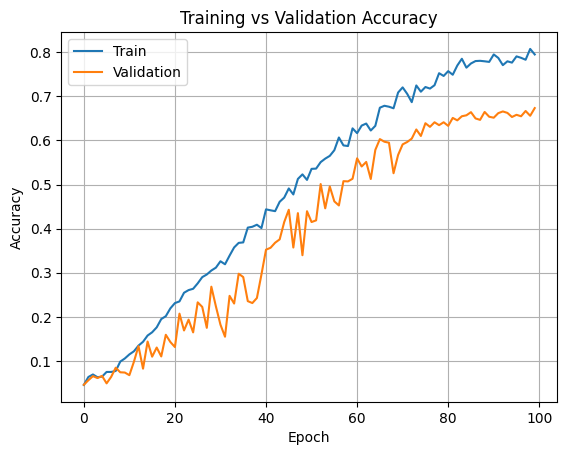

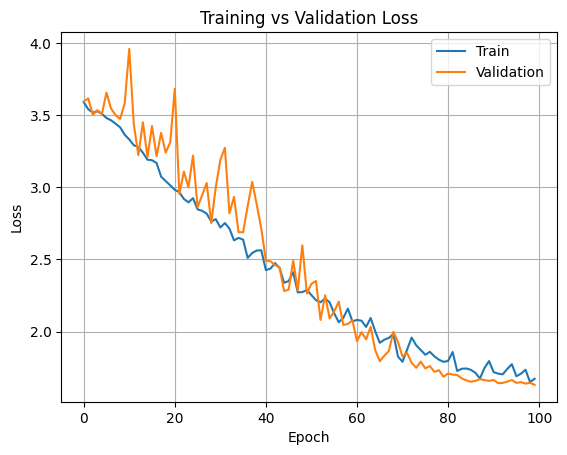

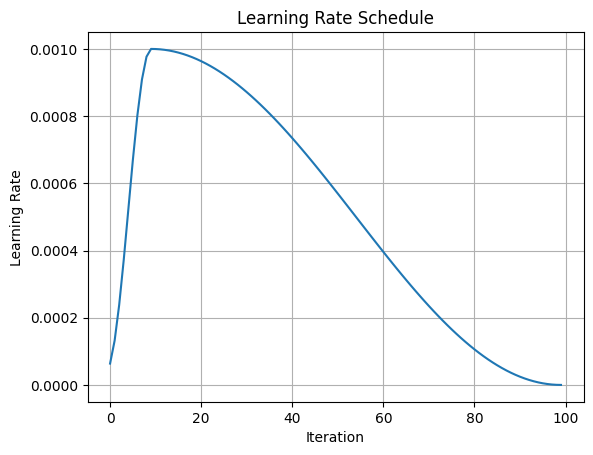

In [ ]:
plot_accuracy(history7)
plot_loss(history7)
plot_learning_rate(history7)

## **Model variant: No Residual Blocks**

**Change**
- Replaced all residual blocks with plain convolutional blocks, removing skip connections while preserving depth and channel dimensions.

**Purpose**
- To evaluate the contribution of residual connections to optimization stability and final accuracy.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Model_8 = Net(n_classes=train_dataset.get_num_classes(), use_residuals=False).to(device)

# Count parameters
total_params = sum(p.numel() for p in Model_8.parameters())
trainable_params = sum(p.numel() for p in Model_8.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 4,872,805
Trainable parameters: 4,872,805


In [ ]:
config8 = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=True,
    save_path="best_noRES_net.pth",
)

criterion8, optimizer8, scheduler8, mixup8 = build_training_components(
    model = Model_8,
    train_loader=train_loader,
    train_dataset=train_dataset,
    config=config8,
)

best_acc8, history8 = train_model(
    model=Model_8,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion8,
    optimizer=optimizer8,
    scheduler=scheduler8,
    mixup=mixup8,
    device=device,
    num_epochs=config8.num_epochs,
    save_path=config8.save_path,
)

Epoch [1/100] | Train Loss: 3.581, Train Acc: 0.044 | Val Loss: 3.535, Val Acc: 0.061 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 3.503, Train Acc: 0.074 | Val Loss: 3.470, Val Acc: 0.083 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 3.439, Train Acc: 0.089 | Val Loss: 3.405, Val Acc: 0.088 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 3.385, Train Acc: 0.104 | Val Loss: 3.669, Val Acc: 0.077 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 3.364, Train Acc: 0.110 | Val Loss: 3.828, Val Acc: 0.077 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 3.331, Train Acc: 0.117 | Val Loss: 3.521, Val Acc: 0.082 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 3.303, Train Acc: 0.120 | Val Loss: 3.292, Val Acc: 0.115 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 3.281, Train Acc: 0.132 | Val Loss: 3.528, Val Acc: 0.091 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 3.214, Train Acc: 0.153 | Val Loss: 3.254, Val Acc: 0.110 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 3.160, Train Acc: 0.184 | Val Loss: 3.147, Val Acc: 0.159 | LR

In [ ]:
best_model8 = Model_8

best_model8.load_state_dict(
    torch.load(config8.save_path, map_location=device)
)

best_model8.to(device)

test_loss8, test_acc8, test_prec8, test_recall8, test_f18 = evaluate(best_model8, test_loader, criterion8, device)

print(f"Test Loss: {test_loss8:.3f}")
print(f"Test Accuracy: {test_acc8:.3f}")

Test Loss: 1.606
Test Accuracy: 0.698


In [ ]:
results.append({
    "Model": "No Residual",
    "Test Loss": test_loss8,
    "Test Accuracy": test_acc8,
    "Test Precision": test_prec8,
    "Test Recall": test_recall8,
    "Test F1": test_f18
})

In [ ]:
all_histories["No Residual"] = history8

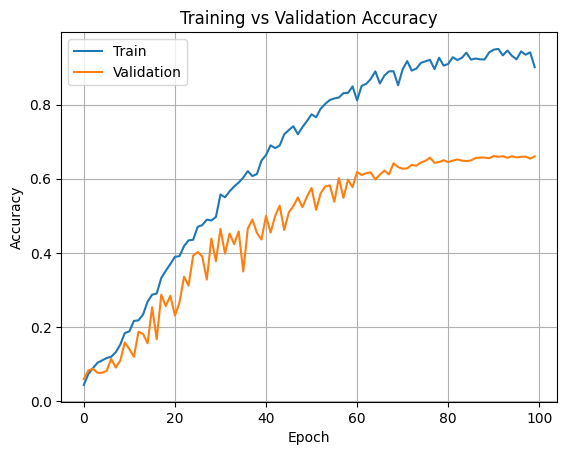

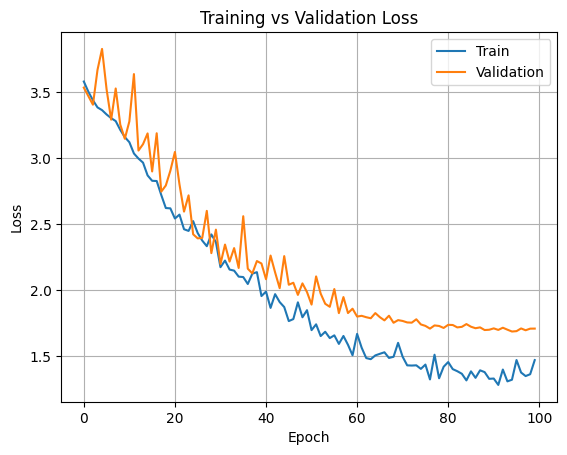

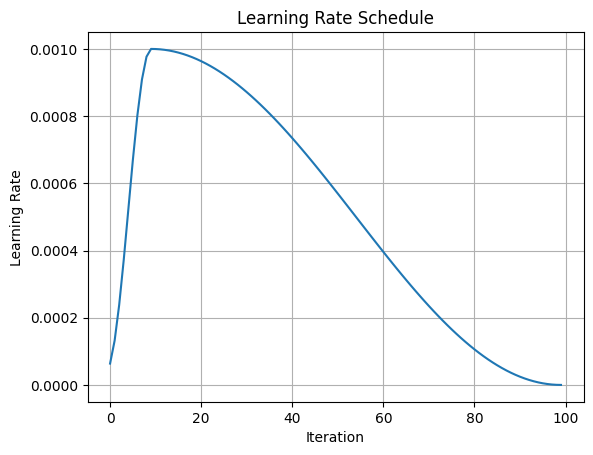

In [ ]:
plot_accuracy(history8)
plot_loss(history8)
plot_learning_rate(history8)

## **Model variant: No Label Smoothing**

**Change**
- Disabled label smoothing in the cross-entropy loss, using hard one-hot target labels during training.

**Purpose**
- To assess the effect of label smoothing on model calibration and generalization.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Model_9 = Net(n_classes=train_dataset.get_num_classes()).to(device)

# Count parameters
total_params = sum(p.numel() for p in Model_9.parameters())
trainable_params = sum(p.numel() for p in Model_9.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,317,349
Trainable parameters: 11,317,349


In [ ]:
config9 = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=False,
    use_mixup=True,
    save_path="best_noSMOOTH_net.pth",
)

criterion9, optimizer9, scheduler9, mixup9 = build_training_components(
    model = Model_9,
    train_loader=train_loader,
    train_dataset=train_dataset,
    config=config9,
)

best_acc9, history9 = train_model(
    model=Model_9,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion9,
    optimizer=optimizer9,
    scheduler=scheduler9,
    mixup=mixup9,
    device=device,
    num_epochs=config9.num_epochs,
    save_path=config9.save_path,
)

Epoch [1/100] | Train Loss: 3.568, Train Acc: 0.046 | Val Loss: 3.501, Val Acc: 0.075 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 3.456, Train Acc: 0.076 | Val Loss: 3.434, Val Acc: 0.069 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 3.383, Train Acc: 0.087 | Val Loss: 3.417, Val Acc: 0.072 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 3.348, Train Acc: 0.099 | Val Loss: 3.377, Val Acc: 0.092 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 3.344, Train Acc: 0.102 | Val Loss: 3.511, Val Acc: 0.075 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 3.278, Train Acc: 0.117 | Val Loss: 3.614, Val Acc: 0.069 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 3.238, Train Acc: 0.120 | Val Loss: 3.268, Val Acc: 0.101 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 3.202, Train Acc: 0.134 | Val Loss: 3.205, Val Acc: 0.116 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 3.118, Train Acc: 0.152 | Val Loss: 3.172, Val Acc: 0.122 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 3.085, Train Acc: 0.167 | Val Loss: 3.257, Val Acc: 0.115 | LR

In [ ]:
best_model9 = Model_9

best_model9.load_state_dict(
    torch.load(config9.save_path, map_location=device)
)

best_model9.to(device)

test_loss9, test_acc9, test_prec9, test_recall9, test_f19 = evaluate(best_model9, test_loader, criterion9, device)

print(f"Test Loss: {test_loss9:.3f}")
print(f"Test Accuracy: {test_acc9:.3f}")

Test Loss: 1.118
Test Accuracy: 0.698


In [ ]:
results.append({
    "Model": "No LabelSmoothing",
    "Test Loss": test_loss9,
    "Test Accuracy": test_acc9,
    "Test Precision": test_prec9,
    "Test Recall": test_recall9,
    "Test F1": test_f19
})

In [ ]:
all_histories["No LabelSmoothing"] = history9

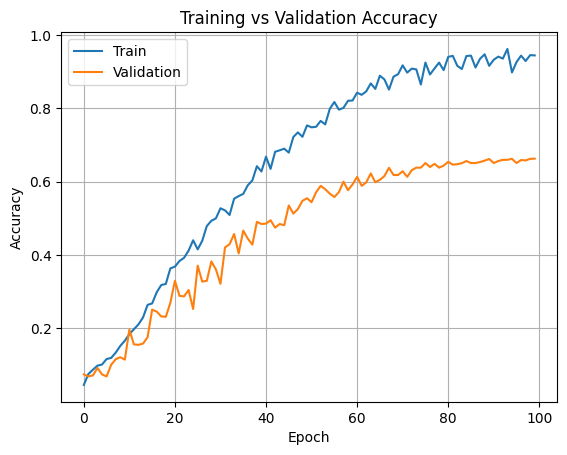

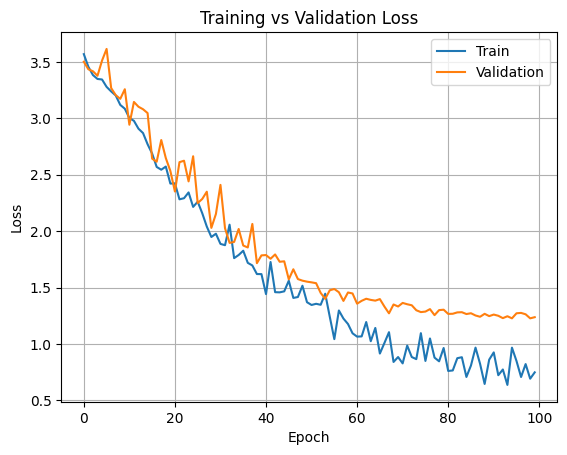

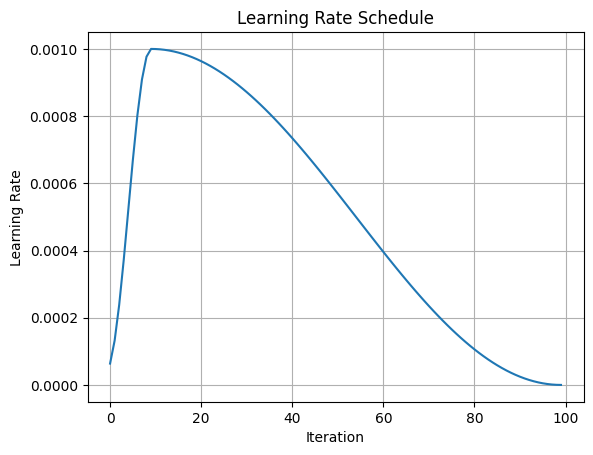

In [ ]:
plot_accuracy(history9)
plot_loss(history9)
plot_learning_rate(history9)

## **Model variant: No Learning Rate Scheduler**

**Change**
- Disabled the learning rate scheduler, training the model with a constant learning rate throughout all epochs.

**Purpose**
- To evaluate the impact of dynamic learning rate scheduling on convergence speed and final performance.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize model with fresh weights
Model_10 = Net(n_classes=train_dataset.get_num_classes()).to(device)

# Count parameters
total_params = sum(p.numel() for p in Model_10.parameters())
trainable_params = sum(p.numel() for p in Model_10.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,317,349
Trainable parameters: 11,317,349


In [ ]:
config10 = TrainConfig(
    use_scheduler=False,
    use_label_smoothing=True,
    use_mixup=True,
    save_path="best_noLRSCHED_net.pth",
)

criterion10, optimizer10, scheduler10, mixup10 = build_training_components(
    model = Model_10,
    train_loader=train_loader,
    train_dataset=train_dataset,
    config=config10,
)

best_acc10, history10 = train_model(
    model=Model_10,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion10,
    optimizer=optimizer10,
    scheduler=scheduler10,
    mixup=mixup10,
    device=device,
    num_epochs=config10.num_epochs,
    save_path=config10.save_path,
)

Epoch [1/100] | Train Loss: 3.640, Train Acc: 0.029 | Val Loss: 3.596, Val Acc: 0.042 | LR: 1.00e-03
Epoch [2/100] | Train Loss: 3.590, Train Acc: 0.042 | Val Loss: 3.591, Val Acc: 0.038 | LR: 1.00e-03
Epoch [3/100] | Train Loss: 3.558, Train Acc: 0.048 | Val Loss: 3.556, Val Acc: 0.056 | LR: 1.00e-03
Epoch [4/100] | Train Loss: 3.526, Train Acc: 0.057 | Val Loss: 3.492, Val Acc: 0.060 | LR: 1.00e-03
Epoch [5/100] | Train Loss: 3.504, Train Acc: 0.068 | Val Loss: 3.525, Val Acc: 0.056 | LR: 1.00e-03
Epoch [6/100] | Train Loss: 3.485, Train Acc: 0.062 | Val Loss: 3.508, Val Acc: 0.059 | LR: 1.00e-03
Epoch [7/100] | Train Loss: 3.476, Train Acc: 0.063 | Val Loss: 3.442, Val Acc: 0.067 | LR: 1.00e-03
Epoch [8/100] | Train Loss: 3.462, Train Acc: 0.071 | Val Loss: 3.440, Val Acc: 0.067 | LR: 1.00e-03
Epoch [9/100] | Train Loss: 3.453, Train Acc: 0.070 | Val Loss: 3.426, Val Acc: 0.069 | LR: 1.00e-03
Epoch [10/100] | Train Loss: 3.445, Train Acc: 0.082 | Val Loss: 3.436, Val Acc: 0.070 | LR

In [ ]:
best_model10 = Model_10

best_model10.load_state_dict(
    torch.load(config10.save_path, map_location=device)
)

best_model10.to(device)

test_loss10, test_acc10, test_prec10, test_recall10, test_f110 = evaluate(best_model10, test_loader, criterion10, device)

print(f"Test Loss: {test_loss10:.3f}")
print(f"Test Accuracy: {test_acc10:.3f}")

Test Loss: 2.279
Test Accuracy: 0.457


In [ ]:
results.append({
    "Model": "No LR Scheduler",
    "Test Loss": test_loss10,
    "Test Accuracy": test_acc10,
    "Test Precision": test_prec10,
    "Test Recall": test_recall10,
    "Test F1": test_f110
})

In [ ]:
all_histories["No LR Scheduler"] = history10

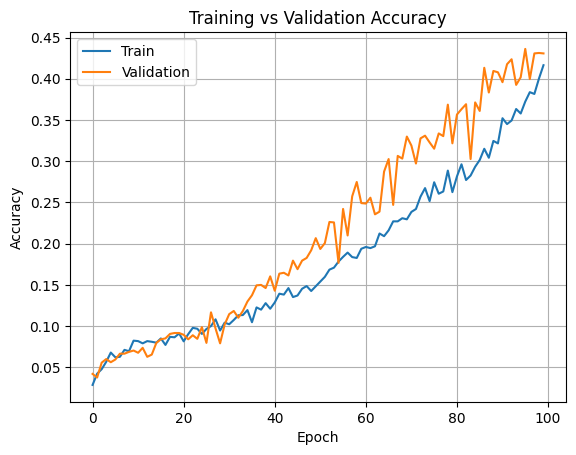

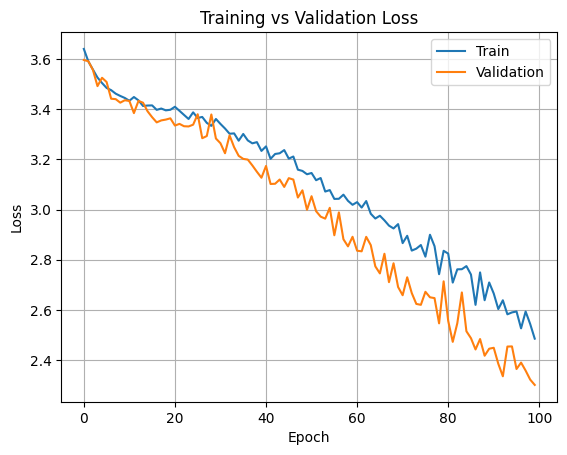

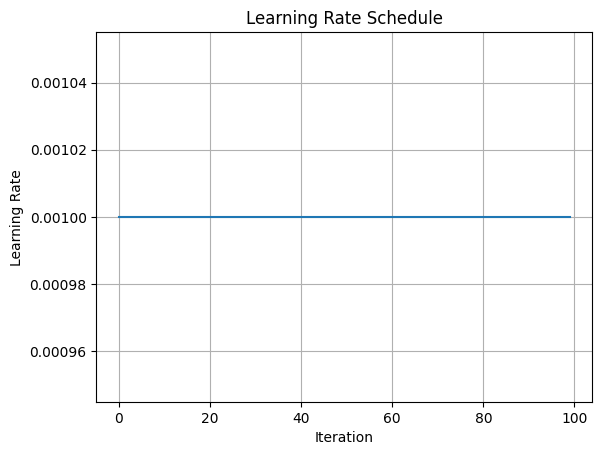

In [ ]:
plot_accuracy(history10)
plot_loss(history10)
plot_learning_rate(history10)

## **RECAP**



In [ ]:
plt.figure()
plt.plot(history["val_acc"])
plt.plot(history2["val_acc"])
plt.plot(history3["val_acc"])
plt.plot(history4["val_acc"])
plt.plot(history5["val_acc"])
plt.plot(history6["val_acc"])
plt.plot(history7["val_acc"])
plt.plot(history8["val_acc"])
plt.plot(history9["val_acc"])
plt.plot(history10["val_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy - Ablation Study")
plt.legend(["Baseline", "No Batch Norm", "No Pooling", "No Dropout", "No MixUp", "No Data Augmentation", "No Stem layer", "No Residual blocks", "No Label Smoothing", "No LR scheduler"])
plt.grid(True)
plt.show()

In [ ]:
plt.figure()
plt.plot(history["train_loss"])
plt.plot(history2["train_loss"])
plt.plot(history3["train_loss"])
plt.plot(history4["train_loss"])
plt.plot(history5["train_loss"])
plt.plot(history6["train_loss"])
plt.plot(history7["train_loss"])
plt.plot(history8["train_loss"])
plt.plot(history9["train_loss"])
plt.plot(history10["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss - Ablation Study")
plt.legend(["Baseline", "No Batch Norm", "No Pooling", "No Dropout", "No MixUp", "No Data Augmentation", "No Stem layer", "No Residual blocks", "No Label Smoothing", "No LR scheduler"])
plt.grid(True)
plt.show()

In [ ]:
df_results = pd.DataFrame(results)
df_results = df_results.round(4)
df_results

In [ ]:
df_results.to_csv("ablation_test_results.csv", index=False)

In [ ]:
import json

with open("ablation_histories.json", "w") as f:
    json.dump(all_histories, f, indent=4)

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

In [ ]:
# Part 2A: Fine-tune ResNet-18 with the same hyperparameters as Part 1

from torchvision import models
from torchvision.models import ResNet18_Weights

# Load pretrained ResNet-18 (ImageNet-1K V1 weights)
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Replace the final classifier layer for 37 pet classes
num_classes = train_dataset.get_num_classes()
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

# Count parameters
total_params = sum(p.numel() for p in resnet18.parameters())
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f"Using device: {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


Using device: cuda
Total parameters: 11,195,493
Trainable parameters: 11,195,493


In [ ]:
# Train ResNet-18 with the same config as Part 1 best model (full baseline)

config_2a = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=True,
    save_path="best_resnet18_2a.pth",
)

criterion_2a, optimizer_2a, scheduler_2a, mixup_2a = build_training_components(
    model=resnet18,
    train_loader=train_loader,
    train_dataset=train_dataset,
    config=config_2a,
)

best_acc_2a, history_2a = train_model(
    model=resnet18,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_2a,
    optimizer=optimizer_2a,
    scheduler=scheduler_2a,
    mixup=mixup_2a,
    device=device,
    num_epochs=config_2a.num_epochs,
    save_path=config_2a.save_path,
)

Epoch [1/100] | Train Loss: 2.710, Train Acc: 0.470 | Val Loss: 1.600, Val Acc: 0.765 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 1.671, Train Acc: 0.821 | Val Loss: 1.260, Val Acc: 0.820 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 1.471, Train Acc: 0.871 | Val Loss: 1.325, Val Acc: 0.782 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 1.518, Train Acc: 0.851 | Val Loss: 1.531, Val Acc: 0.740 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 1.546, Train Acc: 0.839 | Val Loss: 1.722, Val Acc: 0.640 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 1.593, Train Acc: 0.809 | Val Loss: 1.889, Val Acc: 0.599 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 1.588, Train Acc: 0.783 | Val Loss: 1.879, Val Acc: 0.592 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 1.604, Train Acc: 0.805 | Val Loss: 2.219, Val Acc: 0.504 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 1.522, Train Acc: 0.809 | Val Loss: 2.084, Val Acc: 0.546 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 1.606, Train Acc: 0.808 | Val Loss: 1.942, Val Acc: 0.573 | LR

In [ ]:
# Evaluate ResNet-18 Part 2A on test set

resnet18.load_state_dict(
    torch.load(config_2a.save_path, map_location=device)
)
resnet18.to(device)

test_loss_2a, test_acc_2a, test_prec_2a, test_recall_2a, test_f1_2a = evaluate(resnet18, test_loader, criterion_2a, device)

print(f"Part 2A - ResNet-18 Fine-tuned (same hyperparameters as Part 1)")
print(f"Test Loss: {test_loss_2a:.3f}")
print(f"Test Accuracy: {test_acc_2a:.3f}")

Part 2A - ResNet-18 Fine-tuned (same hyperparameters as Part 1)
Test Loss: 1.134
Test Accuracy: 0.848


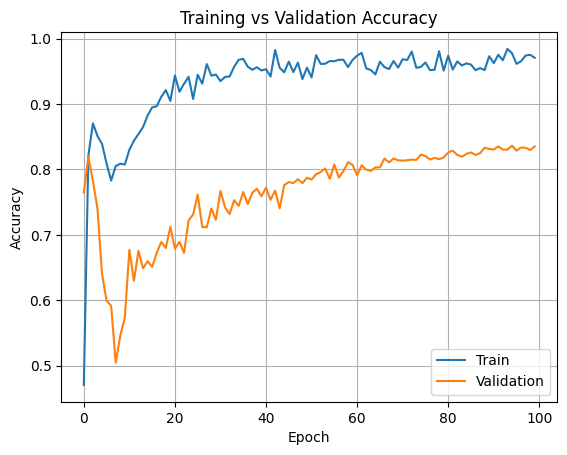

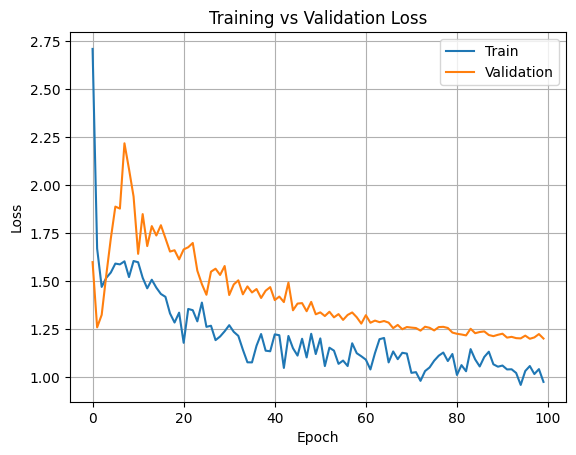

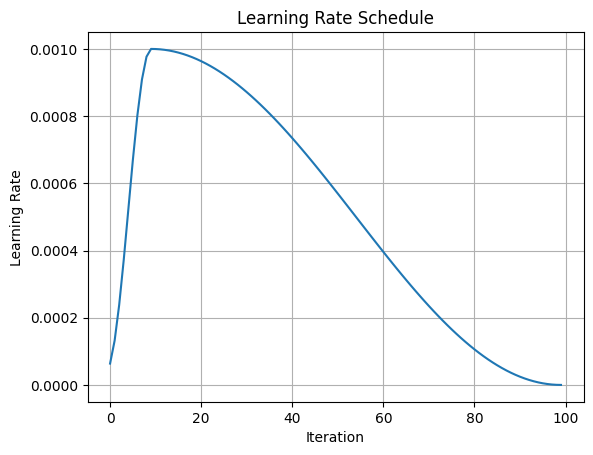

In [ ]:
plot_accuracy(history_2a)
plot_loss(history_2a)
plot_learning_rate(history_2a)

## Part 2B: Fine-tune ResNet-18 with optimized hyperparameters

**Changes from Part 2A:**
- **Lower learning rate**: Pretrained models benefit from smaller learning rates (1e-4 to 3e-4) to avoid destroying pretrained features
- **Layer-wise learning rate decay**: Lower learning rate for earlier layers, higher for classifier (discriminative fine-tuning)
- **Longer warmup**: Gradual warmup helps stabilize training when fine-tuning
- **Freeze backbone initially** (optional): Train only the classifier first, then unfreeze the backbone

**Justification:**
- Transfer learning best practices suggest using smaller learning rates for pretrained layers (Yosinski et al., "How transferable are features in deep neural networks?", NeurIPS 2014)
- The pretrained features are already well-optimized for image classification; aggressive updates can degrade them

In [ ]:
# Part 2B: Fine-tune ResNet-18 with optimized hyperparameters

# Re-initialize pretrained ResNet-18
resnet18_2b = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_classes = train_dataset.get_num_classes()
resnet18_2b.fc = nn.Sequential(
    nn.Dropout(p=0.4, inplace=False),
    nn.Linear(in_features=512, out_features=num_classes, bias=True)
)

resnet18_2b = resnet18_2b.to(device)

resnet18_2b.requires_grad_ = False
resnet18_2b.fc.requires_grad_ = True

print(f"Using device: {device}")
total_params = sum(p.numel() for p in resnet18_2b.parameters())
trainable_params = sum(p.numel() for p in resnet18_2b.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
Total parameters: 11,195,493
Trainable parameters: 11,195,493


In [ ]:
# Train with optimized hyperparameters for transfer learning
# Using discriminative learning rates: lower LR for backbone, higher for classifier

# Define parameter groups with different learning rates
#backbone_params = [p for name, p in resnet18_2b.named_parameters() if 'fc' not in name]
#classifier_params = [p for name, p in resnet18_2b.named_parameters() if 'fc' in name]

# Optimized for transfer learning: lower base LR
#base_lr = 1e-4
#classifier_lr = 1e-3

#optimizer_2b = optim.AdamW([
#    {'params': backbone_params, 'lr': base_lr},
#    {'params': classifier_params, 'lr': classifier_lr}
#], weight_decay=0.01)

base_lr = 1e-3
classifier_lr = 1e-5
num_epochs_2b = 100

optimizer_fc = torch.optim.AdamW(model_2B.fc.parameters(), lr=base_lr, weight_decay=1e-3)
optimizer_full = torch.optim.AdamW(model_2B.parameters(), lr=classifier_lr, weight_decay=1e-3)

scheduler_fc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_fc, T_max=num_epochs_2b)
scheduler_full = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_full, T_max=num_epochs_2b)

# Use label smoothing for regularization
criterion_2b = nn.CrossEntropyLoss(label_smoothing=0.05)

# OneCycleLR with optimized max_lr for fine-tuning
#num_epochs_2b = 100
#scheduler_2b = optim.lr_scheduler.OneCycleLR(
#    optimizer_2b,
#    max_lr=[base_lr * 10, classifier_lr * 10],  # Peak LR during cycle
#    epochs=num_epochs_2b,
#    steps_per_epoch=len(train_loader),
#    pct_start=0.1,  # 10% warmup
#    anneal_strategy='cos'
#)

# MixUp augmentation
#mixup_2b = v2.MixUp(alpha=0.2, num_classes=num_classes)

In [ ]:
# Train the model
best_acc_2b, history_2b = train_model(
    model=resnet18_2b,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_2b,
    optimizer=optimizer_2b,
    scheduler=scheduler_2b,
    mixup=NoMixUp(),
    device=device,
    num_epochs=num_epochs_2b,
    save_path="best_resnet18_2b.pth",
)

Epoch [1/100] | Train Loss: 2.378, Train Acc: 0.567 | Val Loss: 1.307, Val Acc: 0.820 | LR: 6.35e-05
Epoch [2/100] | Train Loss: 1.527, Train Acc: 0.845 | Val Loss: 1.269, Val Acc: 0.823 | LR: 1.32e-04
Epoch [3/100] | Train Loss: 1.509, Train Acc: 0.854 | Val Loss: 1.414, Val Acc: 0.767 | LR: 2.38e-04
Epoch [4/100] | Train Loss: 1.596, Train Acc: 0.825 | Val Loss: 1.620, Val Acc: 0.695 | LR: 3.72e-04
Epoch [5/100] | Train Loss: 1.848, Train Acc: 0.750 | Val Loss: 2.012, Val Acc: 0.607 | LR: 5.21e-04
Epoch [6/100] | Train Loss: 1.950, Train Acc: 0.709 | Val Loss: 2.358, Val Acc: 0.505 | LR: 6.69e-04
Epoch [7/100] | Train Loss: 2.005, Train Acc: 0.694 | Val Loss: 3.440, Val Acc: 0.364 | LR: 8.03e-04
Epoch [8/100] | Train Loss: 2.041, Train Acc: 0.685 | Val Loss: 2.250, Val Acc: 0.501 | LR: 9.09e-04
Epoch [9/100] | Train Loss: 1.994, Train Acc: 0.689 | Val Loss: 2.381, Val Acc: 0.478 | LR: 9.77e-04
Epoch [10/100] | Train Loss: 2.069, Train Acc: 0.698 | Val Loss: 2.681, Val Acc: 0.460 | LR

In [ ]:
# Evaluate ResNet-18 Part 2B on test set

resnet18_2b.load_state_dict(
    torch.load("best_resnet18_2b.pth", map_location=device)
)
resnet18_2b.to(device)

test_loss_2b, test_acc_2b, test_prec_2b, test_recall_2b, test_f1_2b = evaluate(resnet18_2b, test_loader, criterion_2b, device)

print(f"Part 2B - ResNet-18 Fine-tuned (optimized hyperparameters)")
print(f"Test Loss: {test_loss_2b:.3f}")
print(f"Test Accuracy: {test_acc_2b:.3f}")

Part 2B - ResNet-18 Fine-tuned (optimized hyperparameters)
Test Loss: 1.196
Test Accuracy: 0.840


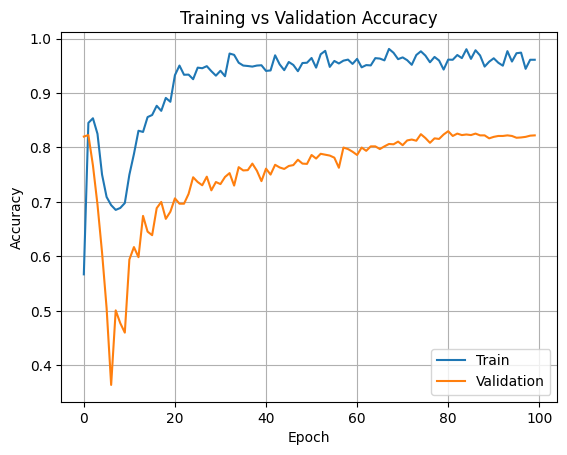

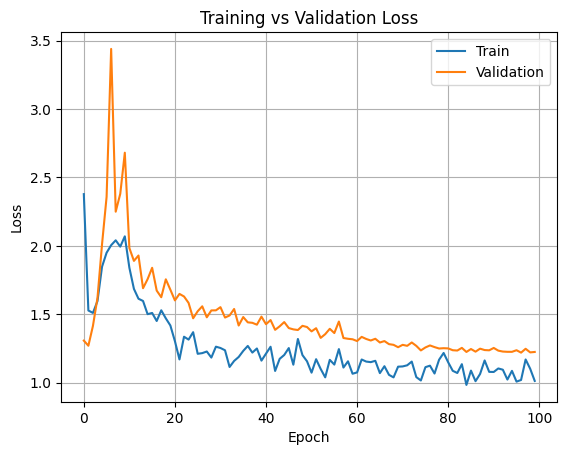

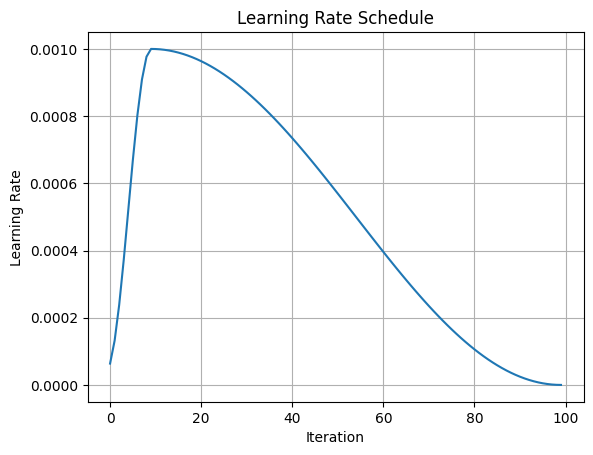

In [ ]:
plot_accuracy(history_2b)
plot_loss(history_2b)
plot_learning_rate(history_2b)

In [ ]:
# Summary comparison: Part 2A vs Part 2B
print("Part 2 Summary: ResNet-18 Fine-tuning Results")
print(f"\nPart 2A (same hyperparameters as Part 1):")
print(f"  Test Accuracy: {test_acc_2a:.3f}")
print(f"\nPart 2B (optimized hyperparameters for transfer learning):")
print(f"  Test Accuracy: {test_acc_2b:.3f}")
print(f"\nImprovement: {(test_acc_2b - test_acc_2a) * 100:.2f} percentage points")